<a href="https://colab.research.google.com/github/kynk94/11th_Project/blob/master/dance/normalization_by_%EC%84%9C%EC%84%9D%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


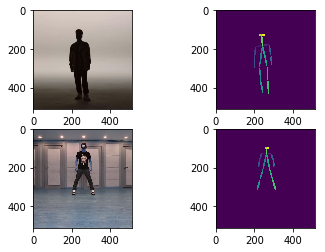

In [11]:
from tqdm import tqdm_notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path


target_img = cv2.imread('/gdrive/My Drive/source/target/test_label_ori/00001.png')[:,:,0]
target_img_rgb = cv2.imread('/gdrive/My Drive/source/target/test_img/00001.png')
source_img = cv2.imread('/gdrive/My Drive/source/test_label_ori/00001.png')[:,:,0]
source_img_rgb = cv2.imread('/gdrive/My Drive/source/test_img/00001.png')

path = '/gdrive/My Drive/source/test_label_ori/'
save_dir = Path('/gdrive/My Drive/source/')
output = save_dir.joinpath('normalized_label')
output.mkdir(exist_ok=True)
head_dir = save_dir.joinpath('normalized_head')
head_dir.mkdir(exist_ok=True)
pose_dir = Path('/gdrive/My Drive/source/pose_source.npy')
pose_cord = np.load(str(pose_dir))

plt.subplot(222)
plt.imshow(target_img)
plt.subplot(221)
plt.imshow(target_img_rgb)
plt.subplot(224)
plt.imshow(source_img)
plt.subplot(223)
plt.imshow(source_img_rgb)
plt.savefig('norm.png')
plt.show()



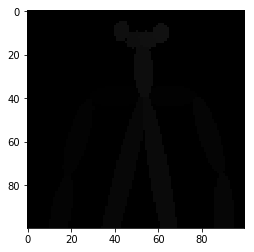

In [13]:
def get_scale(label_img):
    any1 = label_img.any(axis=1)
    linspace1 = np.arange(len(any1))
    head_x, height = linspace1[list(any1)][0], len(linspace1[list(any1)])
    any0 = label_img[head_x, :] != 0
    linspace2 = np.arange(len(any0))
    head_y = int(np.mean(linspace2[list(any0)]))
    return (head_x,head_y),height

target_head,target_height = get_scale(target_img)
target_head_x = target_head[0]
target_head_y = target_head[1]

source_head,source_height = get_scale(source_img)


new_head_pose = []

for img_idx in tqdm_notebook(range(len(os.listdir(path))-990)):
    img = cv2.imread(path+'{:05}.png'.format(img_idx))
    source_rsize = cv2.resize(img,
                              (int(img.shape[0] * target_height / source_height),
                               int(img.shape[1] * target_height / source_height)))

    source_pad = np.pad(source_rsize, ((1000, 1000), (1000, 1000),(0,0)), mode='edge')

    source_head_rs, source_height_rs = get_scale(source_pad[:,:,0])
    source_head_rs_x = source_head_rs[0]
    source_head_rs_y = source_head_rs[1]

    new_source = source_pad[
                 (source_head_rs_x - target_head_x):(source_head_rs_x + (target_img.shape[0] - target_head_x)),
                 int((source_pad.shape[1] - target_img.shape[1])/2):int((source_pad.shape[1]-(source_pad.shape[1] - target_img.shape[1])/2))
                 ]
    new_source_head, _ = get_scale(new_source[:,:,0])

    source_head_x, source_head_y = source_head
    source_cord_y, source_cord_x = pose_cord[0]

    new_head_y = int(new_source_head[1] - (source_head_y - source_cord_y))
    new_head_x = int(new_source_head[0] - (source_head_x - source_cord_x) * (target_height / source_height))

    crop_size = 50
    new_head_pose.append([new_head_y,new_head_x])
    head = img[int(new_head_x - crop_size): int(new_head_x + crop_size),
           int(new_head_y - crop_size): int(new_head_y + crop_size), :]
    plt.imshow(head)
    plt.savefig(str(head_dir.joinpath('pose_{}.jpg'.format(img_idx))))


    cv2.imwrite(str(output) + '/{:05}.png'.format(img_idx),new_source)

pose_cords_arr = np.array(new_head_pose, dtype=np.int)
np.save(str((save_dir.joinpath('pose_source_norm.npy'))), pose_cords_arr)